In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [2]:
path = 'ab_test_results_aggregated_views_clicks_2.csv'
df = pd.read_csv(path)
df

,user_id,group,views,clicks
0,1,control,10.0,0.0
1,2,control,1.0,0.0
2,3,control,1.0,0.0
3,4,control,2.0,0.0
4,5,control,3.0,0.0
...,...,...,...,...
119995,119996,test,9.0,0.0
119996,119997,test,2.0,1.0
119997,119998,test,20.0,1.0
119998,119999,test,6.0,1.0


In [3]:
df.head()

,user_id,group,views,clicks
0,1,control,10.0,0.0
1,2,control,1.0,0.0
2,3,control,1.0,0.0
3,4,control,2.0,0.0
4,5,control,3.0,0.0


In [4]:
df.nunique()

user_id    120000
group           2
views         111
clicks         10
dtype: int64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,120000.0,60000.500000,34641.160489,1.0,30000.75,60000.5,90000.25,120000.0
views,120000.0,4.991075,5.915200,1.0,2.00,3.0,6.00,205.0
clicks,120000.0,0.182692,0.472547,0.0,0.00,0.0,0.00,9.0
Conversion rate%,120000.0,3.665101,11.781180,0.0,0.00,0.0,0.00,100.0


In [12]:
duplication_values = df.duplicated().sum()
print(f"duplication values : {duplication_values}")

duplication values : 0


In [6]:
# Шаг 1: Создаем новый столбец 'Conversion rate%' с конверсией в процентах
df['Conversion rate%'] = df['clicks'] / df['views'] * 100

# Шаг 2: Вычисляем среднюю конверсию для контрольной группы
ave_conversion_control = df.loc[df['group'] == 'control', 'Conversion rate%'].mean()

# Шаг 3: Вычисляем среднюю конверсию для тестовой группы
ave_conversion_test = df.loc[df['group'] == 'test', 'Conversion rate%'].mean()

# Шаг 4: Выводим результаты
print("The average conversion rate in the test group is:", ave_conversion_test)
print("The average conversion rate in the control group is:", ave_conversion_control)


The average conversion rate in the test group is: 3.8647582531410847
The average conversion rate in the control group is: 3.465443309280596


Когда мы смотрим конверсию, мы видим, что есть разница между двумя группами. Возможно, что новая функция, примененная к тестовой группе, получает больше кликов. Но этот результат может быть вводящим в заблуждение.

Поэтому нам нужно выяснить, является ли эта разница статистически значимой.

Чтобы применить A/B-тестирование, набор данных должен удовлетворять предположениям о нормальности и гомогенности дисперсии. Только в этом случае мы можем перейти к проверке гипотез.

Если предположения о нормальности и гомогенности дисперсии выполняются, мы применяем независимый двухвыборочный t-тест (параметрический тест).
Если предположения о нормальности и гомогенности дисперсии не выполняются, мы используем тест Манна-Уитни (непараметрический тест). Как проверить предположение о нормальности? Для начала мы выдвигаем гипотезы H0 и H1.

H0: Распределение данных о конверсии в обеих группах является нормальным.

H1: Распределение данных о конверсии в обеих группах не является нормальным.

In [8]:
shapiro(df.loc[df.group == 'test', 'clicks'])

ShapiroResult(statistic=0.43864309787750244, pvalue=0.0)

In [9]:
shapiro(df.loc[df.group == 'control', 'clicks'])

ShapiroResult(statistic=0.41856634616851807, pvalue=0.0)

H0 отвергается, потому что значение p <0.05. Предположение о нормальности не выполняется.

Поэтому мы будем использовать тест Манна-Уитни.

H0: Нет статистически значимой разницы между двумя группами в частоте кликов на целевую страницу.

H1: Существует разница.

In [13]:
size = df.groupby('group').count().reset_index()[['group','user_id']]
test_size = size.loc[size['group'] == 'test', 'user_id'].values[0]
control_size = size.loc[size['group'] == 'control', 'user_id'].values[0]
print('test size:',test_size)
print('control size:',control_size)

test size: 60000
control size: 60000


In [18]:
df['ctr'] = df['clicks']/df['views']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           120000 non-null  int64  
 1   group             120000 non-null  object 
 2   views             120000 non-null  float64
 3   clicks            120000 non-null  float64
 4   Conversion rate%  120000 non-null  float64
 5   ctr               120000 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 5.5+ MB


In [19]:
control_data = df[df['group'] == 'control']['ctr'].tolist()
test_data = df[df['group'] == 'test']['ctr'].tolist()

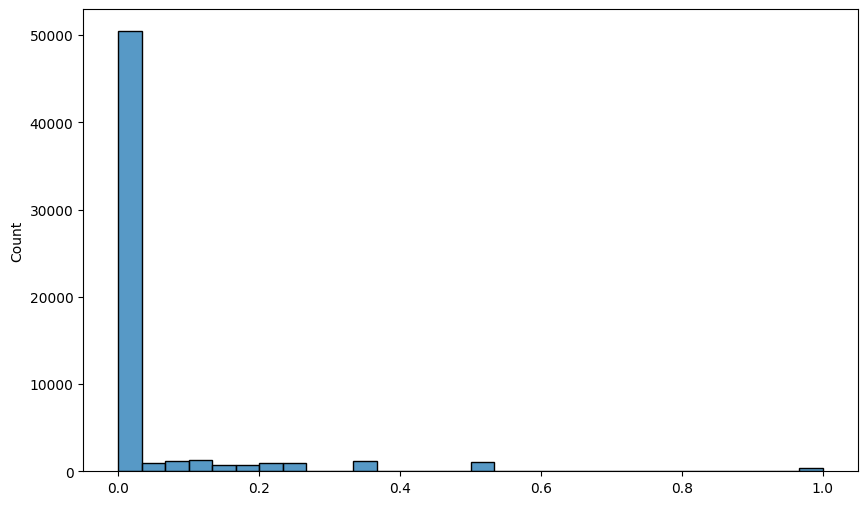

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(test_data, bins=30, stat="count")
plt.show()

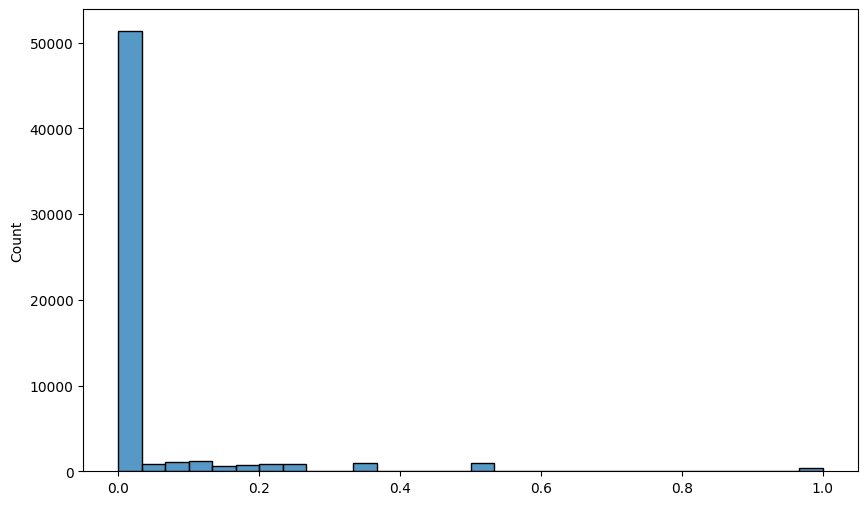

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(control_data, bins=30, stat="count")
plt.show()

Гистограмма показывает, что данные выборки отклоняются от нормального распределения.

In [10]:
mannwhitneyu(df.loc[(df.group == 'test'), 'clicks'],
             df.loc[(df.group == 'control'), 'clicks'])

MannwhitneyuResult(statistic=1827378002.0, pvalue=3.362997071095112e-13)

H0 отвергается, потому что значение p <0.05. Другими словами, статистически можно сказать, что существует разница между двумя группами.

Средний коэффициент конверсии составлял 3.46% в группе Control, а в группе Test этот показатель увеличился до 3.86%.

В результате мы можем сказать, что это увеличение коэффициента не является случайным, а статистически подтверждено.